# Numerical results for RTS-96

In [1]:
####### IMPORTS ########
include("../src/tmp_inst_rts96.jl")
include("../src/TemporalInstanton.jl")
include("../src/TemporalInstanton2.jl")

using TemporalInstanton,TemporalInstanton2

####### LOAD DATA ########
psData = psDataLoad()

# unpack psDL (boilerplate):
(Sb,f,t,r,x,b,Y,bustype,
Gp,Gq,Dp,Dq,Rp,Rq,
Pmax,Pmin,Qmax,Qmin,Plim,
Vg,Vceiling,Vfloor,
busIdx,N,Nr,Ng,k) = unpack_psDL(psData)

res = r
reac = x

####### LINK DATA ########
# Static
Ridx = find(Rp) # Vector of renewable nodes
Y = full(Y) # Full admittance matrix (ref not removed)
ref = 1 # Index of ref node
k = k # Conventional generator participation factors
tau = 0.5 # Heating constant
G0 = [Gp,Gp,Gp]
D0 = [Dp,Dp,Dp]
P0 = [0.5.*Rp,Rp,1.5*Rp]
kQobj = 0 # Should always be zero; objective has no constant term
c = 0.03 # RHS of line temperature constraint
kQtheta = -c # Move to LHS so we have Q(z) = 0
lines = [(f[i],t[i]) for i in 1:length(f)];

n = size(Y,1)
nr = length(Ridx)
T = int(length(G0)/n) # infer number of time steps

# Create Qobj:
Qobj = tmp_inst_Qobj(n,nr,T)
# Augment Qobj with additional rows and columns of zeros:
Qobj = tmp_inst_pad_Q(full(Qobj),T)

# Create A1 (only A2 changes during opt.):
A1 = full(tmp_inst_A(Ridx,T,Y,ref,k))
A1 = [A1 zeros((n+1)*T,T)]

# Create b:
b = tmp_inst_b(n,T,G0,P0,D0)
# Augment b with new elements:
tmp_inst_pad_b(b,T)

# Create Qtheta:
Qtheta = tmp_inst_Qtheta(n,nr,T)#,tau)

# Form obj and constraint quadratics:
G_of_x = (Qobj,0,kQobj)
Q_of_x = (Qtheta,0,kQtheta)

println("loaded")

loaded


In [2]:
score,x,θ,α,diffs,xopt = loop_through_lines(
    G_of_x,Q_of_x,A1,b,
n,T,tau,Ridx,ref,lines)
println("Unsolved lines: $(sum(score.==Inf))")

Unsolved lines: 6


In [3]:
using Interact
using PyPlot

INFO: Loading help data...


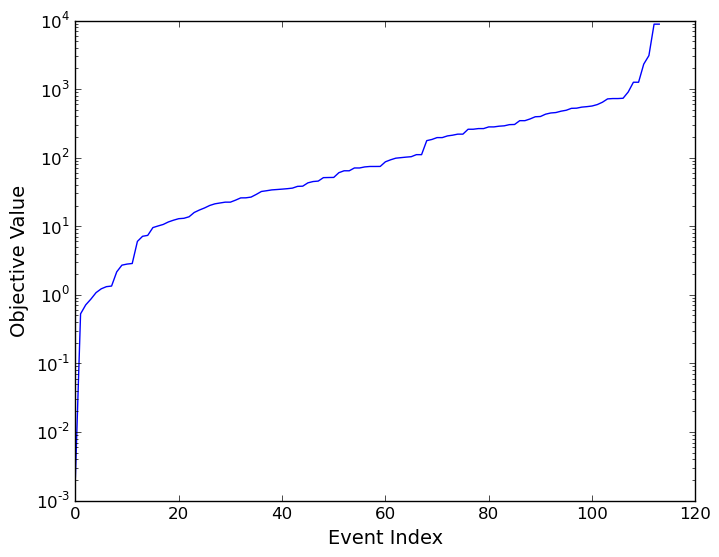

In [13]:
semilogy(sort(score[score.<Inf]))
xlabel("Event Index",fontsize=14)
ylabel("Objective Value",fontsize=14)
#ylim([0,600])

savefig("../images/scores.pdf")

In [4]:
@time(loop_through_lines(
    G_of_x,Q_of_x,A1,b,
n,T,tau,Ridx,ref,lines))

println("solved")

elapsed time: 67.819097441 seconds (14913261356 bytes allocated, 16.59% gc time)
solved


In [6]:
@manipulate for c = 0.01:0.01:0.5
    kQtheta = -c
    Q_of_x = (Qtheta,0,kQtheta)
    score,x,θ,α,diffs = loop_through_lines(
        G_of_x,Q_of_x,A1,b,
        n,T,tau,Ridx,ref,lines[118:118])
    #max_dev = maximum(abs([x[1][1],x[1][2],x[1][3]]))
    sort(P0[find(P0)] + [x[1][1],x[1][2],x[1][3]])
end

Slider{Float64}([Input{Float64}] 0.25,"c",0.25,0.01:0.01:0.5)

54-element Array{Float64,1}:
 -1.17682  
 -0.783641 
 -0.730216 
 -0.202558 
 -0.0557215
  0.0194977
  0.0287793
  0.0425899
  0.0535853
  0.0635791
  0.0654565
  0.0685002
  0.0767611
  ⋮        
  0.741274 
  0.770436 
  0.815073 
  0.850682 
  0.88424  
  1.00853  
  1.0641   
  1.31623  
  1.32228  
  1.67815  
  1.93312  
  2.27311  

## An interesting case

What if the wind forecast increases significantly over the course of a few time steps?

What can this model do that others can't? It can track changes _in time_. In order to be interesting, results must include significant changes in dispatch, demand, or forecast.

What if forecast increases but demand decreases? What if forecast peaks sharply in the last time step?

In [40]:
maximum([x[1][1],x[1][2],x[1][3]])

0.7268332529125381

In [4]:
include("../src/plotResults.jl")
using plotResults
using PyCall
@pyimport IPython.display as IPd

Slider{Int64}([Input{Int64}] 2,"tidx",2,1:3)

Slider{Int64}([Input{Int64}] 60,"eidx",60,1:120)

testResults.dot generated.
Use ";dot -Tsvg testResults.dot -o testResults.svg" to create an SVG.


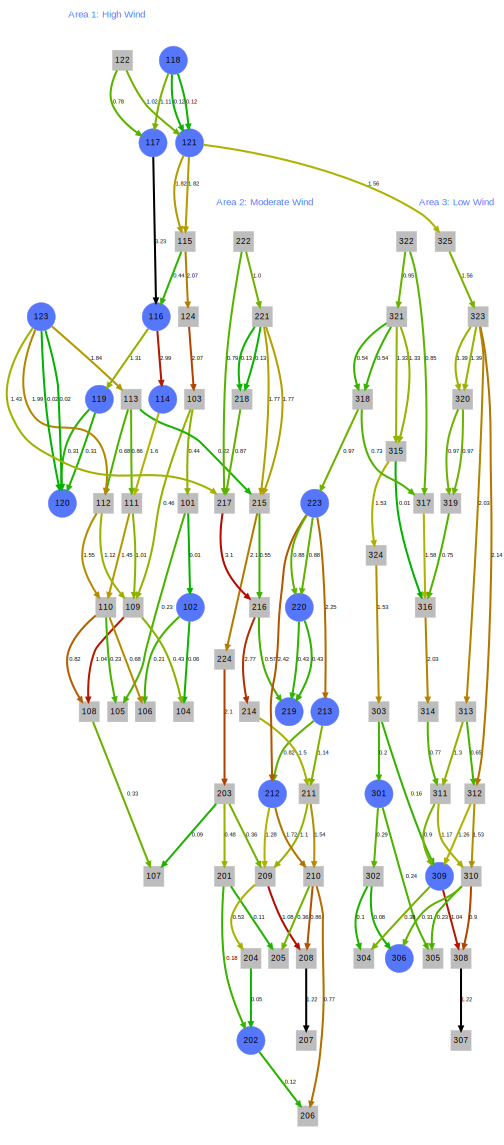

In [35]:
tmpInstRes = temporalInstantonResults(x,θ,α)

name = "testResults"
dim = (7,16)
idx = 118
tidx = 2
@manipulate for tidx=1:T, eidx in 1:length(f)
    # find event index of i-th event:
    idx = find(score.==sort(score)[eidx])[1]
    
    generateDot(name,psData,
    tmpInstRes,
    idx,tidx,
    G0,P0,D0,
    dim)

    run(`dot -Tsvg $(name).dot -o $(name).svg`)
    IPd.SVG("$(name).svg")
end

In [14]:
lines[118]

(73,21)

In [18]:
[busIdx[73] busIdx[21]]

1x2 Array{Float64,2}:
 325.0  121.0

In [37]:
tmpInstRes = temporalInstantonResults(x,θ,α)

name = "line118"
dim = (9,15)
idx = 118
tidx = 2
eidx = 1

# find event index of i-th event:
idx = find(score.==sort(score)[eidx])[1]

generateDot(name,psData,
tmpInstRes,
idx,tidx,
G0,P0,D0,
dim)

run(`dot -Teps $(name).dot -o ../images/$(name).eps`)

line118.dot generated.
Use ";dot -Tsvg line118.dot -o line118.svg" to create an SVG.
